## Задача

- [ ] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [ ] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [ ] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] (+3 балла) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
print("Python version")
print (sys.version)
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Python version
3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


# Датасет

[Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) $-$ датасет с изображениями (28 х 28) элементов одежды. Для обучения были выбраны 10000 фотографий из тестовой выборки.  

In [81]:
df = pd.read_csv('../data/fashion_mnist/fashion-mnist_test.csv')

In [82]:
df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [83]:
df = df.fillna(0)

In [84]:
df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

# EDA

In [85]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
X = df.drop(['label'], axis=1)
y = df['label']

df.drop_duplicates(inplace=True)
print(df.shape)

(9999, 785)


In [87]:
y.unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9])

# PCA

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pca.fit(X)
X_pca = pca.transform(X)

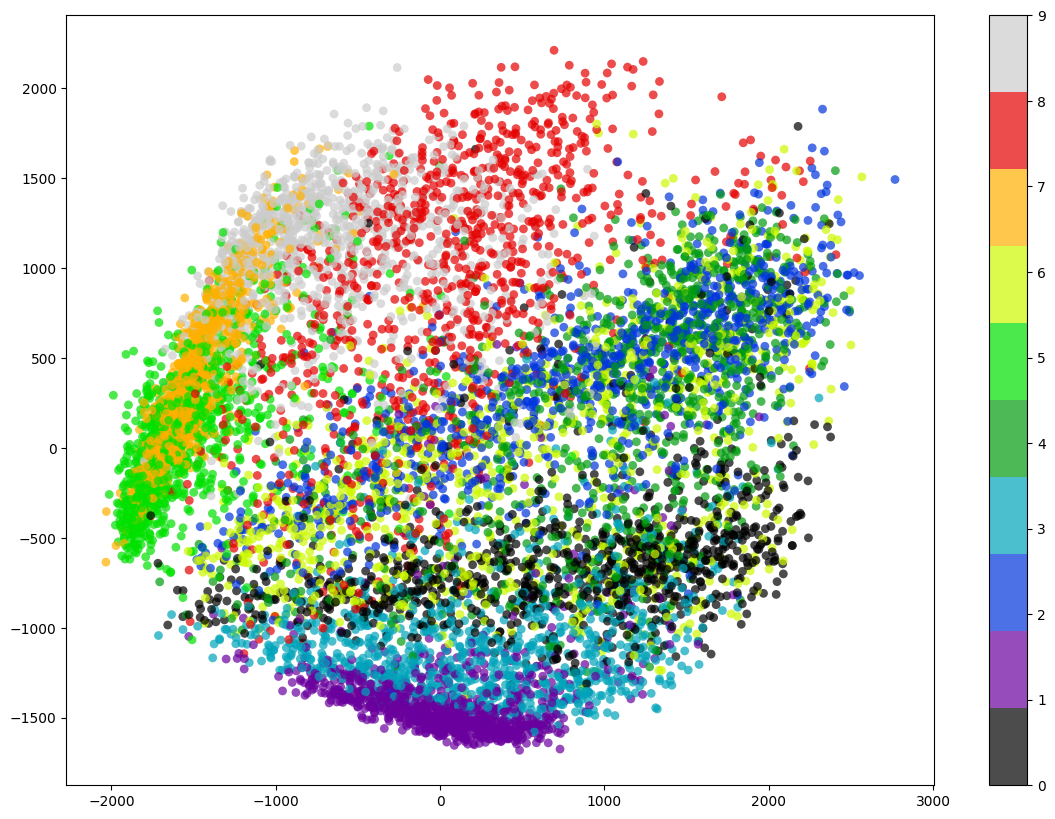

In [89]:
plt.figure(figsize=(14, 10))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()


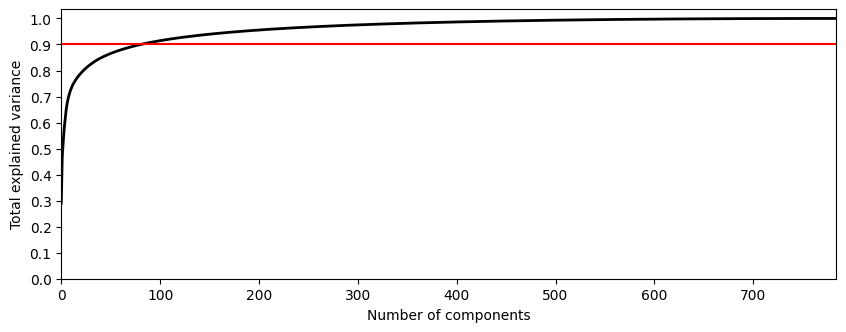

In [90]:
pca = PCA().fit(X)

plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 28 * 28)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')

# t-SNE

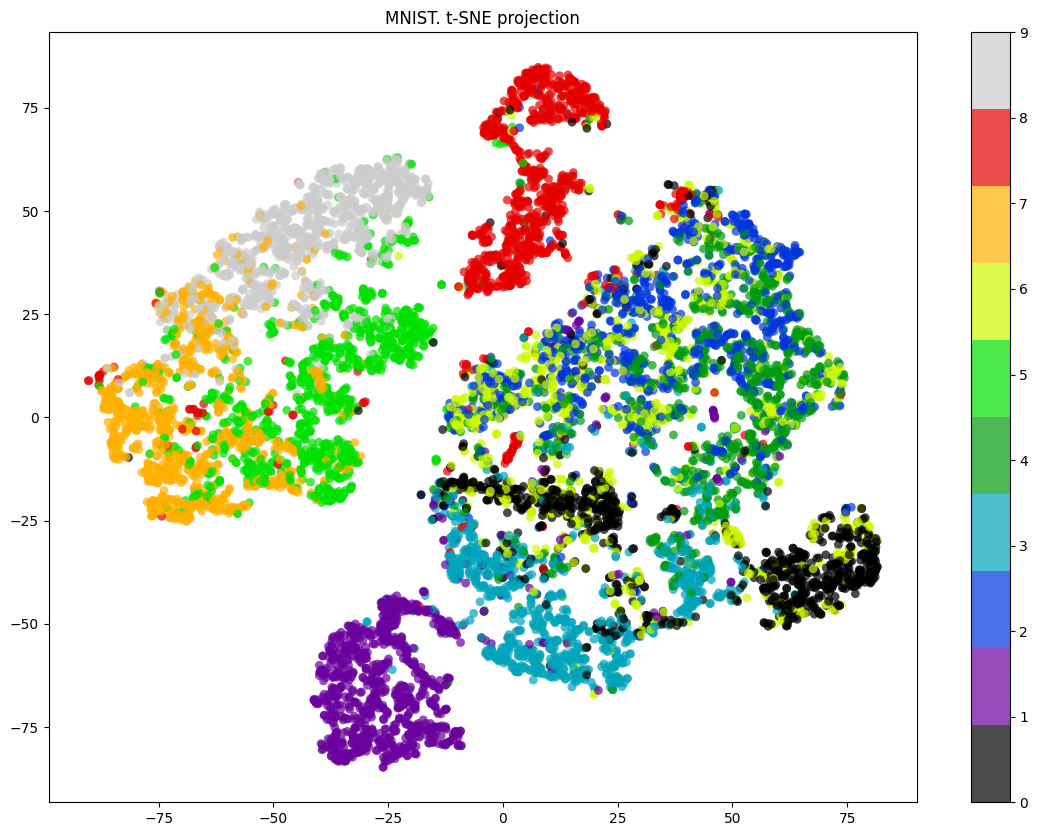

In [91]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)

X_tsne = tsne.fit_transform(X_pca)
plt.figure(figsize=(14, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection");

# Собственная реализация K-Mean

In [92]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted


class My_KMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[
            self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :
        ]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(
                np.linalg.norm(self.cluster_centers_ - new, axis=1)
            )

            self.cluster_centers_ = new

        return self

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def _get_labels(self, x):
        dists_to_center = np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1)
        return np.argmin(dists_to_center, axis=1)


In [93]:
xs = [PCA(n_components=i).fit_transform(X) for i in [25, 80, 500]] + [X]

In [94]:
import itertools, time
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score,
)
from sklearn.base import clone


def train(est, params):
    params_combs = [
        dict(param)
        for param in itertools.product(
            *([(name, v) for v in vs] for (name, vs) in params.items())
        )
    ]

    results = []
    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = time.perf_counter() - start_time

            ari = adjusted_rand_score(y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        res = {
            "cluster": est.__class__.__name__,
            "dimension": x.shape[1],
            "mean fit predict time, s": np.mean(
                [best_ari[1], best_ami[1], best_fmi[1]]
            ),
            "best ari": best_ari[0],
            "best ami": best_ami[0],
            "best fmi": best_fmi[0],
        }

        print(res)
        results.append(res)

    return results


In [95]:
my_k_mean = train(My_KMeans(n_clusters=10, random_state=42), params={})

{'cluster': 'My_KMeans', 'dimension': 25, 'mean fit predict time, s': 0.5742528149999089, 'best ari': 0.3371822618704529, 'best ami': 0.5045685447503476, 'best fmi': 0.40793911947264366}
{'cluster': 'My_KMeans', 'dimension': 80, 'mean fit predict time, s': 1.4804492749999554, 'best ari': 0.3375469716354462, 'best ami': 0.5054081608580684, 'best fmi': 0.40825205144722804}
{'cluster': 'My_KMeans', 'dimension': 500, 'mean fit predict time, s': 16.65471091900008, 'best ari': 0.3365342035738511, 'best ami': 0.5035820973425718, 'best fmi': 0.4073337978139904}
{'cluster': 'My_KMeans', 'dimension': 784, 'mean fit predict time, s': 33.26333251400001, 'best ari': 0.33730217405266255, 'best ami': 0.5042817067846098, 'best fmi': 0.40803394395618714}


In [96]:
from sklearn.cluster import KMeans

k_mean = train(
    KMeans(n_clusters=10, n_init="auto", random_state=42),
    params={"algorithm": ["lloyd", "elkan"]},
)

{'cluster': 'KMeans', 'dimension': 25, 'mean fit predict time, s': 0.4187965629998871, 'best ari': 0.34147820848289845, 'best ami': 0.506703193386558, 'best fmi': 0.41418420740714235}
{'cluster': 'KMeans', 'dimension': 80, 'mean fit predict time, s': 0.2719582990002891, 'best ari': 0.37369454507273386, 'best ami': 0.5222392437777627, 'best fmi': 0.43941814439586313}
{'cluster': 'KMeans', 'dimension': 500, 'mean fit predict time, s': 0.7406563570002618, 'best ari': 0.3577253016780521, 'best ami': 0.5176190350025662, 'best fmi': 0.42557711689981614}
{'cluster': 'KMeans', 'dimension': 784, 'mean fit predict time, s': 1.0995842960001028, 'best ari': 0.3577253016780521, 'best ami': 0.5176190350025662, 'best fmi': 0.42557711689981614}


In [97]:
from sklearn.cluster import DBSCAN

dbscan = train(
    DBSCAN(n_jobs=4), params={"eps": [500, 1000, 1500], "min_samples": [40, 80, 120]}
)


{'cluster': 'DBSCAN', 'dimension': 25, 'mean fit predict time, s': 0.47771499300006326, 'best ari': 0.05138595679342352, 'best ami': 0.2765559032455746, 'best fmi': 0.3182610767432564}
{'cluster': 'DBSCAN', 'dimension': 80, 'mean fit predict time, s': 0.8967614146664952, 'best ari': 0.06780013167171815, 'best ami': 0.13598235902592287, 'best fmi': 0.31608541725157124}
{'cluster': 'DBSCAN', 'dimension': 500, 'mean fit predict time, s': 3.5260948309999853, 'best ari': 0.04467217365320442, 'best ami': 0.2214611494762228, 'best fmi': 0.31608541725157124}
{'cluster': 'DBSCAN', 'dimension': 784, 'mean fit predict time, s': 8.288191429999946, 'best ari': 0.043749260205775714, 'best ami': 0.25575134192948995, 'best fmi': 0.31608541725157124}


In [98]:
results = pd.DataFrame(my_k_mean + k_mean + dbscan)

# Результаты

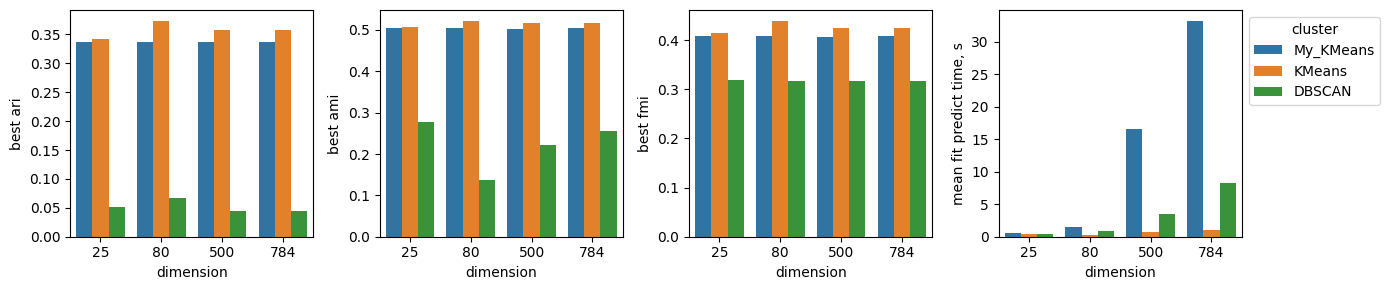

In [99]:
import seaborn as sns

fig, axs = plt.subplots(ncols=4, figsize=(14, 3))

for metric, ax in zip(
    ["best ari", "best ami", "best fmi", "mean fit predict time, s"], axs.flatten()
):
    sns.barplot(results, x="dimension", y=metric, hue="cluster", ax=ax)
    if metric == "mean fit predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()


## Выводы
1. Самой быстрообучающейся моделью из рассмотренных является KMean библиотеки sklearn
2. На данных fashion mnist из рассмотренных можелей хуже всего показала себя модель DBSCAN
3. При уменьшении количества атрибутов время уменьшается в разы